# Simulations of linearly increasing frequency.
## Many points in parameter space

We run simulations on a grid in parameter space to try to delimit roughly a phase diagram. 

In [1]:
import sys
import os
sys.path.insert(0, './magcolloids')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML, clear_output
import jsonpickle
import scipy.optimize as spo
import scipy.spatial as spa 
import magcolloid as mgc
import matplotlib as mpl
import string as st

ureg = mgc.ureg

idx = pd.IndexSlice

%reload_ext autoreload
%autoreload 2
%matplotlib inline

## First a test simulation. 

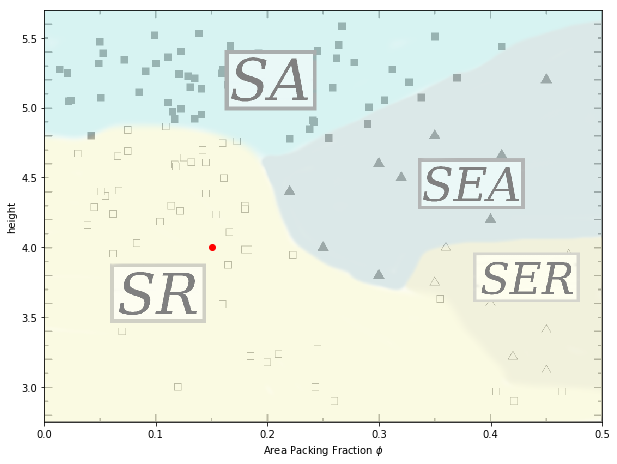

In [2]:
packing = 0.15
height = 4

ax = mgc.draw_exp_phase_diagram()
ax.plot(packing,height,marker='o',color='r',linestyle='none');

In [3]:
def run_simulation(packing, height):
    region, positions = mgc.ordered_dimers(n_of_particles = 150, packing=packing, height = height, r = 1.4, theta = np.pi/2)

    particles = mgc.particles(
        positions*ureg.um,
        radius = 1.4*ureg.um,
        susceptibility = 0.4,
        diffusion=0.073*ureg.um**2/ureg.s,
        density = 1000*ureg.kg/ureg.m**3,
        temperature=300*ureg.K)

    field = mgc.field(magnitude = 7.28*ureg.mT, frequency = "1.667e-6*time*1e-6"*ureg.MHz,
                      angle = 27*ureg.degrees, multibody_iter=2)

    world = mgc.world(particles, temperature = 300*ureg.K,
                      region=region*ureg.um, boundaries = ['p','p','f'], walls = [False,False,True],
                      dipole_cutoff = 30*ureg.um)

    sim = mgc.sim(dir_name = "C:/Users/aortiza/Desktop/Test2/",file_name="freq_variation",stamp_time=False,
           timestep = 1e-4*ureg.s, framerate = 75*ureg.Hz, total_time = 60*ureg.sec,
           particles = particles, world = world, field = field, output=["x","y","z","mux","muy","muz","fx","fy"])

    sim.generate_scripts()
    sim.run()

    sim.load()
    trj = sim.lazy_read[::]

    anim = mgc.animate_trj(trj,sim,start=0,step=10,speedup=10)
    anim.save(sim.base_name+".avi",writer = "ffmpeg")
    return sim, trj

In [4]:
%%time
sim, trj = run_simulation(packing, height)

Wall time: 7min 41s


# Define the points in parameter space to calculate.

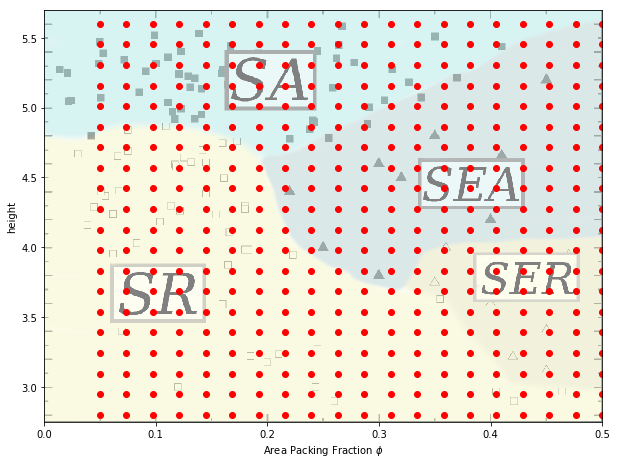

In [9]:
packing = np.linspace(0.05,0.5,20)
height =  np.linspace(2.8,5.6,20)

packing, height = np.meshgrid(packing,height)

ax = mgc.draw_exp_phase_diagram()
ax.plot(packing,height,marker='o',color='r',linestyle='none');

In [12]:
import csv

def run_simulation(packing, height):
    region, positions = mgc.ordered_dimers(n_of_particles = 150, packing=packing, height = height, r = 1.4, theta = np.pi/2)

    particles = mgc.particles(
        positions*ureg.um,
        radius = 1.4*ureg.um,
        susceptibility = 0.4,
        diffusion=0.073*ureg.um**2/ureg.s,
        density = 1000*ureg.kg/ureg.m**3,
        temperature=300*ureg.K)

    field = mgc.field(magnitude = 7.28*ureg.mT, frequency = "1.667e-6*time*1e-6"*ureg.MHz,
                      angle = 27*ureg.degrees, multibody_iter=2)

    world = mgc.world(particles, temperature = 300*ureg.K,
                      region=region*ureg.um, boundaries = ['p','p','f'], walls = [False,False,True],
                      dipole_cutoff = 30*ureg.um)

    #filename = "param_grid_phi%2.2f_h%2.2f"%(packing,height)
    filename = "param_grid"
    directory = "D:/ParamGrid/"

    sim = mgc.sim(dir_name = directory,file_name=filename,stamp_time=True,
           timestep = 1e-4*ureg.s, framerate = 75*ureg.Hz, total_time = 60*ureg.sec,
           particles = particles, world = world, field = field, output=["x","y","z","mux","muy","muz","fx","fy"])

    sim.generate_scripts()
    sim.run()

    sim.load()
    trj = sim.lazy_read[::]

    anim = mgc.animate_trj(trj,sim,start=0,step=10,speedup=10)
    anim.save(sim.base_name+".avi",writer = "ffmpeg")

    with open(os.path.join(directory,"catalogue.dat"),"a") as f:
        writer = csv.writer(f,delimiter="\t")
        writer.writerow([filename,packing,height])

    return sim, trj

In [13]:
for p,h in zip(packing.flatten(),height.flatten()):
    run_simulation(p,h)

In [14]:
def get_names(directory,ext='.dat'):
    base_names = [os.path.join(root,os.path.splitext(file)[0]) 
              for root, dirs, files in os.walk(directory) 
              for file in files 
              if file.endswith(ext)]
    base_names = list(np.sort(np.array(base_names)))
    return base_names 

directory = "D:/ParamGrid/"
names = get_names(directory,ext=".jp")

The catalogue name was accidentally stored before the timestamp was placed. For this, I am creating a second catalogue with the ordered names and the parameters

In [15]:
catalogue = pd.read_csv(os.path.join(directory,"catalogue.dat"),sep="\t",names = ["name","phi","h"])
catalogue.name = [os.path.split(n)[-1] for n in names]
catalogue.to_csv(os.path.join(directory,"catalogue2.dat"),sep="\t")